In [2]:
import os

import matplotlib.pyplot as plt
import pandas as pd
import torch
from tqdm import tqdm

while os.path.basename(os.getcwd()) != "T2T_ViT":
    os.chdir('..')

from models.t2t_vit import t2t_vit_14
from vit_shapley.modules.surrogate import Surrogate
from vit_shapley.CIFAR_10_Dataset import CIFAR_10_Dataset, CIFAR_10_Datamodule, PROJECT_ROOT, apply_masks_to_batch

if torch.cuda.device_count() > 1:
    torch.cuda.set_device(5)

In [2]:
datamodule = CIFAR_10_Datamodule(num_players=196, num_mask_samples=1, paired_mask_samples=False)
datamodule.setup()
data = next(iter(datamodule.train_dataloader()))

images = data['images']
labels = data['labels']
masks = data['masks']
print(images.shape, labels.shape, masks.shape)

torch.Size([32, 3, 224, 224]) torch.Size([32]) torch.Size([32, 1, 196])


<font size="12">Target model visualization</font>

In [3]:
from utils import load_transferred_model
target_model = load_transferred_model("t2t_vit", device="cuda")
target_model.eval()

# Predict with the model.
logits = target_model(images.cuda())
# With Plain ViT and swin, use model(...).logits instead of just model(...).
if hasattr(logits, "logits"):
    logits = logits.logits
print(f'logits shape is {tuple(logits.shape)}')
preds = torch.argmax(logits, dim=1)

adopt performer encoder for tokens-to-token


logits shape is (32, 10)


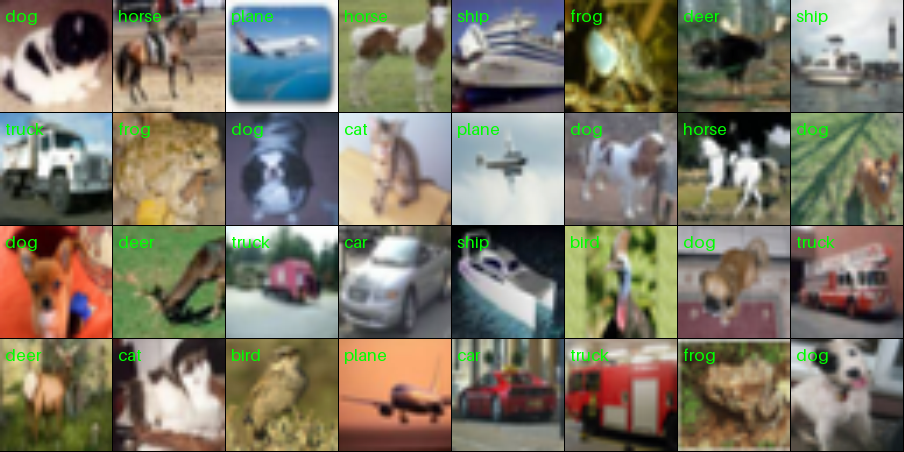

In [4]:
colors = [(0, 255, 0) if l == p else (255, 0, 0) for l, p in zip(labels, preds)]
CIFAR_10_Dataset.to_image_grid(images, preds, colors, scale=1/2)

In [5]:
def test_without_masks(model: torch.nn.Module, dataloader: torch.utils.data.DataLoader, device="cuda") -> None:
    with torch.no_grad():
        model.to(device)
        correct, total = 0, 0
        progress = tqdm(dataloader)
        for d in progress:
            images, targets, masks = d['images'], d['labels'], d['masks']
            images, targets = images.to(device), targets.to(device)
            logits = model(images)
            if hasattr(logits, "logits"):
                logits = logits.logits
            _, predicted = logits.max(dim=1)
            total += targets.shape[0]
            correct += predicted.eq(targets).sum().item()
            progress.set_description(f'Accuracy: {100.0 * correct / total:.2f}%')

test_without_masks(target_model, datamodule.test_dataloader(), "cuda")

Accuracy: 97.50%: 100%|██████████| 313/313 [00:16<00:00, 19.29it/s]


<font size="12">Surrogate model visualization</font>

In [6]:
n_masks_per_image = 2
num_players = 196
datamodule = CIFAR_10_Datamodule(num_players=num_players, num_mask_samples=n_masks_per_image, paired_mask_samples=True)
datamodule.setup()
data = next(iter(datamodule.train_dataloader()))

images = data['images']
labels = data['labels']
masks = data['masks']

In [7]:
print(images.shape, labels.shape, masks.shape)
images_masked, masks_masked, labels_masked = apply_masks_to_batch(images, masks, labels)
print(images_masked.shape, labels_masked.shape, masks_masked.shape)

torch.Size([32, 3, 224, 224]) torch.Size([32]) torch.Size([32, 2, 196])
torch.Size([64, 3, 224, 224]) torch.Size([64]) torch.Size([64, 196])


In [8]:
surrogate = Surrogate.load_from_checkpoint(
    PROJECT_ROOT / "saved_models/surrogate/cifar10/_t2t_vit_player16_lr0.0001_wd0.0_b256_epoch19.ckpt",
    # PROJECT_ROOT / "saved_models/surrogate/cifar10/_vit_player16_lr0.0001_wd0.0_b256_epoch19.ckpt",
    # PROJECT_ROOT / "saved_models/surrogate/cifar10/_swin_player16_lr0.0002_wd0.0_b256_epoch19.ckpt",
    # PROJECT_ROOT / "saved_models/surrogate/cifar10/_player196_lr1e-05_wd0.0_b128_epoch49.ckpt",
    # PROJECT_ROOT / "saved_models/surrogate/cifar10/_player16_lr1e-05_wd0.0_b256_epoch28.ckpt",
    map_location="cuda",
    strict=False,    # It's OK to ignore "target_model.*" being saved checkpoint but not in Surrogate for evaluation.
    # backbone_name="t2t_vit"  # Needs to be specified for older checkpoints.
)
surrogate.eval()
pass

adopt performer encoder for tokens-to-token


/home/mwrochna/.conda/envs/mw_play/lib/python3.11/site-packages/pytorch_lightning/core/saving.py:177: Found keys that are not in the model state dict but in the checkpoint: ['target_model.cls_token', 'target_model.pos_embed', 'target_model.tokens_to_token.attention1.w', 'target_model.tokens_to_token.attention1.kqv.weight', 'target_model.tokens_to_token.attention1.kqv.bias', 'target_model.tokens_to_token.attention1.proj.weight', 'target_model.tokens_to_token.attention1.proj.bias', 'target_model.tokens_to_token.attention1.norm1.weight', 'target_model.tokens_to_token.attention1.norm1.bias', 'target_model.tokens_to_token.attention1.norm2.weight', 'target_model.tokens_to_token.attention1.norm2.bias', 'target_model.tokens_to_token.attention1.mlp.0.weight', 'target_model.tokens_to_token.attention1.mlp.0.bias', 'target_model.tokens_to_token.attention1.mlp.2.weight', 'target_model.tokens_to_token.attention1.mlp.2.bias', 'target_model.tokens_to_token.attention2.w', 'target_model.tokens_to_token.

logits shape is (64, 10)
preds.shape=torch.Size([64]), labels_masked.shape=torch.Size([64])


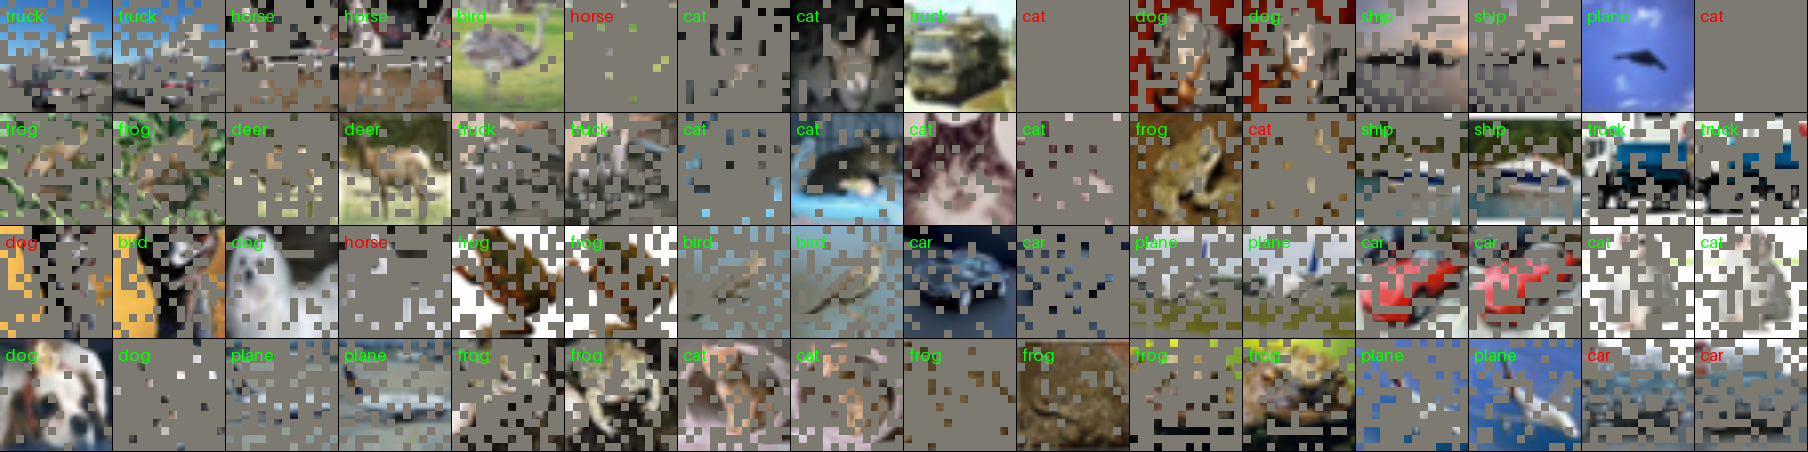

In [9]:
logits = surrogate(images_masked.to(surrogate.device))
print(f'logits shape is {tuple(logits.shape)}')
preds = torch.argmax(logits, dim=1).cpu()
print(f'{preds.shape=}, {labels_masked.shape=}')
colors = [(0, 255, 0) if l == p else (255, 0, 0) for l, p in zip(labels_masked, preds)]
CIFAR_10_Dataset.to_image_grid(images_masked, preds, colors, scale=1/2, n_columns=n_masks_per_image * 8)

In [10]:
test_without_masks(surrogate, datamodule.test_dataloader())

Accuracy: 97.97%: 100%|██████████| 313/313 [00:16<00:00, 19.33it/s]


# Performance on masked images

In [11]:
def test_masked(model: torch.nn.Module, dataloader: torch.utils.data.DataLoader, device="cuda") -> None:
    results = []
    masked_percentages = []
    with torch.no_grad():
        model.to(device)
        correct, total = 0, 0
        progress = tqdm(dataloader)
        for d in progress:
            images, targets, masks = d['images'], d['labels'], d['masks']
            images, targets, masks = images.to(device), targets.to(device), masks.to(device)
            images, masks, targets = apply_masks_to_batch(images, masks, targets)
            logits = model(images)
            if hasattr(logits, "logits"):
                logits = logits.logits
            _, predicted = logits.max(dim=1)
            total += targets.shape[0]
            correct += predicted.eq(targets).sum().item()
            results.extend(predicted.eq(targets).cpu().numpy())
            masked_percentages.extend((1 - masks).to(torch.float).mean(dim=1).cpu().numpy() * 100)
            progress.set_description(f'Accuracy: {100.0 * correct / total:.2f}%')
    return pd.DataFrame({'result': results, 'masked %': masked_percentages})

all_results = {}

In [12]:
all_results["target"] = test_masked(target_model, datamodule.test_dataloader())

Accuracy: 68.08%: 100%|██████████| 313/313 [00:28<00:00, 11.13it/s]


In [13]:
all_results["surrogate"] = test_masked(surrogate, datamodule.test_dataloader())

Accuracy: 85.35%: 100%|██████████| 313/313 [00:28<00:00, 10.97it/s]


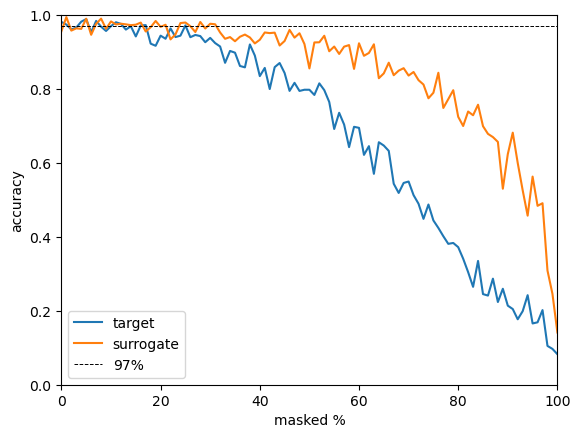

In [14]:
bucket_size = 1.0
for k, df in all_results.items():
    df['masked %'] = df['masked %'].div(bucket_size).round().astype(int).mul(bucket_size)

plt.figure()
for k, df in all_results.items():
    plt.plot(df.groupby('masked %').mean(), label=k)
plt.plot([0, 100], [0.97, 0.97], color='black', linestyle='dashed', linewidth=0.7, label='97%')
plt.legend()
plt.xlabel('masked %')
plt.ylabel('accuracy')
plt.xlim(0, 100)
plt.ylim(0, 1)
plt.show()